# Bayesian Fusion of Nighttime Lights, NDVI, and Road Density in Cuba
This notebook walks through an **exploratory data analysis (EDA)** and a **Bayesian hierarchical model** that estimates a latent economic activity index for Cuba on a 500 m grid.  We combine three satellite‐derived proxies:
1. **VIIRS Nighttime Lights** (`cuba_viirs_2024.tif`)
2. **NDVI** (`cuba_ndvi_2024.tif`)
3. **Road Density** (`cuba_osm_road_density_2024.tif`)

The model specification follows the project description I gave in the midterm, with a Gaussian Markov Random Field (ICAR) prior.

In [13]:
import numpy as np
import xarray as xr
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import pymc as pm
import arviz as az
from tqdm.auto import tqdm

plt.rcParams['figure.figsize'] = (8, 6)

## 1  Load and align the rasters

In [3]:
# Update the paths if necessary
paths = {
    'lights': '/Users/chrisperez/Desktop/stat288-finalproject/data/cuba_viirs_2024.tif',
    'ndvi':   '/Users/chrisperez/Desktop/stat288-finalproject/data/cuba_ndvi_2024.tif',
    'roads':  '/Users/chrisperez/Desktop/stat288-finalproject/data/cuba_osm_road_density_2024.tif',
}

data_arrays = {}
for key, p in paths.items():
    with rasterio.open(p) as f:
        data_arrays[key] = xr.DataArray(
            f.read(1, masked=True),
            dims=('y', 'x'),
            coords={'y': np.arange(f.height) * f.transform[4] + f.transform[5],
                    'x': np.arange(f.width)  * f.transform[0] + f.transform[2]},
            name=key
        )
print({k: da.shape for k, da in data_arrays.items()})

{'lights': (753, 2409), 'ndvi': (753, 2409), 'roads': (753, 2409)}


### Quick look at each proxy

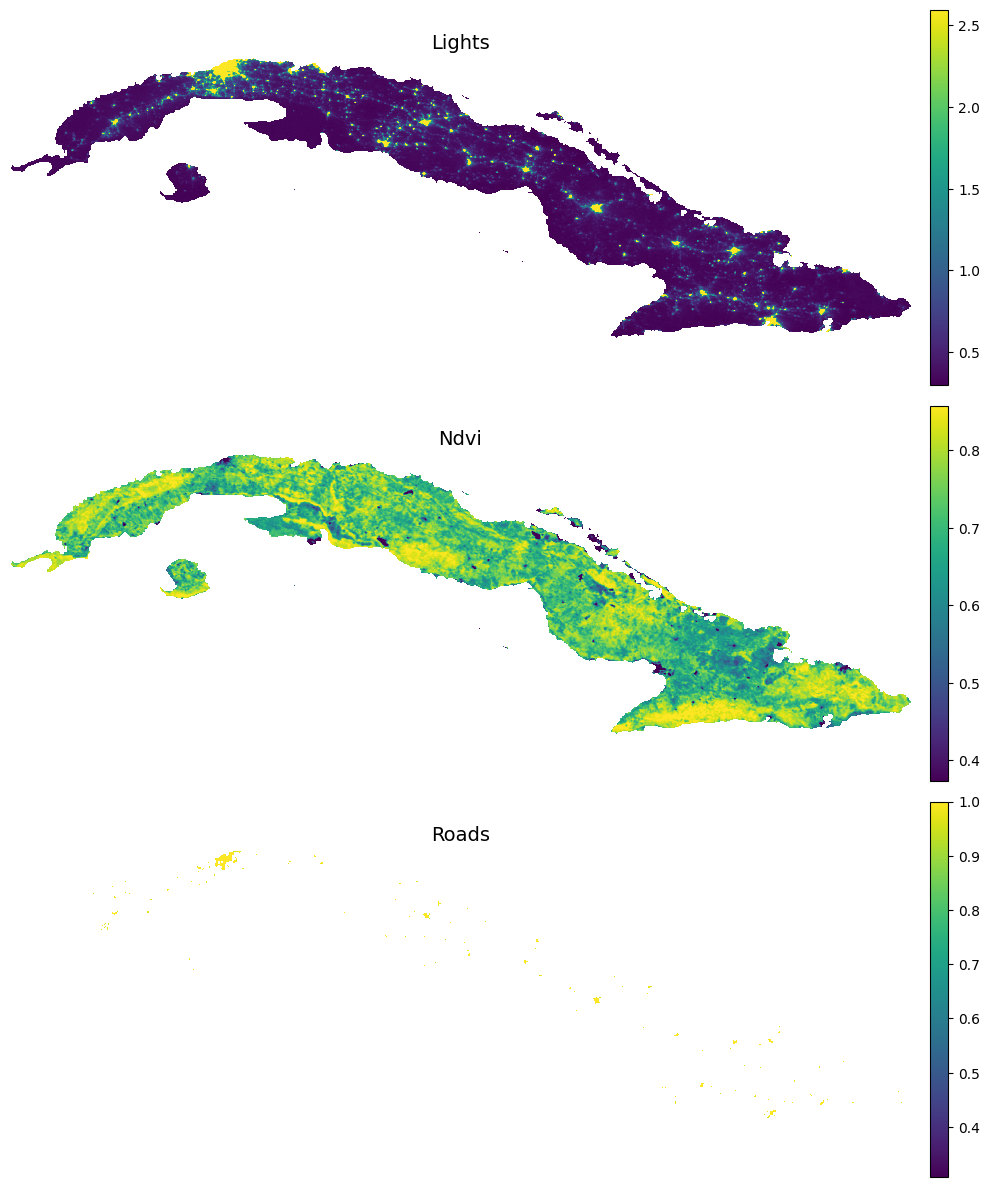

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

for ax, (k, da) in zip(axs, data_arrays.items()):
    im = ax.imshow(da, cmap='viridis', vmin=np.nanpercentile(da, 2), vmax=np.nanpercentile(da, 98))
    ax.set_title(k.capitalize(), fontsize=14)
    ax.axis('off')
    plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)

plt.tight_layout()

## 2  Mask water & standardize proxies

In [6]:
# Build a combined mask (land pixels are True)
mask = (~data_arrays['lights'].isnull()) & (~data_arrays['ndvi'].isnull()) & (~data_arrays['roads'].isnull())

stacked = xr.concat([data_arrays[k] for k in ['lights', 'ndvi', 'roads']], dim='band')
land_vals = stacked.where(mask).values  # shape (3, ny, nx)

# Flatten land pixels
ny, nx = mask.shape
land_idx = np.where(mask.values.ravel())[0]
X = np.vstack([
    data_arrays['lights'].values.ravel()[land_idx],
    data_arrays['ndvi'].values.ravel()[land_idx],
    data_arrays['roads'].values.ravel()[land_idx]
]).T  # shape (N, 3)

# Standardize
means = X.mean(axis=0)
stds = X.std(axis=0)
X_std = (X - means) / stds

print('Means after standardization', X_std.mean(axis=0))
print('Stds  after standardization', X_std.std(axis=0))

Means after standardization [-1.70440302e-17 -7.44887246e-16  7.07011623e-17]
Stds  after standardization [1. 1. 1.]


### Optional: Aggregate to coarser grid to speed up sampling

In [ ]:
coarsen = 30  # 30×30 of 500 m ≈ 15 km

ny_coarse = ny // coarsen
nx_coarse = nx // coarsen

# Build a map from flattened raster index → index in X_std
land_idx_to_Xrow = {idx: i for i, idx in enumerate(land_idx)}

Xc = []
valid = []

for i in range(ny_coarse):
    for j in range(nx_coarse):
        block_idxs = []
        for y in range(i * coarsen, (i + 1) * coarsen):
            for x in range(j * coarsen, (j + 1) * coarsen):
                if 0 <= y < ny and 0 <= x < nx:
                    flat_idx = y * nx + x
                    if flat_idx in land_idx_to_Xrow:
                        block_idxs.append(land_idx_to_Xrow[flat_idx])
        if block_idxs:
            sub_vals = X_std[block_idxs]
            Xc.append(sub_vals.mean(axis=0))
            valid.append((i, j))

Xc = np.vstack(Xc)
print("Coarse cells:", Xc.shape[0])

Coarse cells: 645


## 3  Construct ICAR neighbor structure

In [36]:
# Map (row, col) in coarse grid → row index in Xc
loc_to_idx = {loc: idx for idx, loc in enumerate(valid)}

# Build 4-neighbor connectivity
neighbor_pairs = []
for (i, j), idx in loc_to_idx.items():
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # up, down, left, right
        nbr = (i + di, j + dj)
        if nbr in loc_to_idx:
            neighbor_pairs.append((idx, loc_to_idx[nbr]))
            

# Convert to NumPy arrays
i_idx = np.array([i for i, j in neighbor_pairs])
j_idx = np.array([j for i, j in neighbor_pairs])

## 4  Bayesian hierarchical model

In [43]:
with pm.Model() as model:
    # Data
    x_obs = pm.Data("x_obs", Xc)
    N = Xc.shape[0]

    # Fixed and estimated betas
    beta_lights = 1.0
    beta_ndvi  = pm.Normal("beta_ndvi", mu=0.0, sigma=1.0)
    beta_roads = pm.Normal("beta_roads", mu=0.0, sigma=1.0)
    betas = pm.math.stack([beta_lights, beta_ndvi, beta_roads])

    # Prior on spatial precision (stabilized)
    tau = pm.HalfNormal("tau", sigma=1.0)

    # Non-centered latent field
    z_raw = pm.Normal("z_raw", mu=0.0, sigma=1.0, shape=N)
    z = z_raw / pm.math.sqrt(tau)

    # ICAR smoothing potential
    diffs = z[i_idx] - z[j_idx]
    icar_term = -0.5 * pm.math.sum(diffs**2)
    pm.Potential("icar", icar_term)

    # Observation noise
    sigma = pm.HalfNormal("sigma", sigma=1.0, shape=3)

    # Linear model
    mu = z[:, None] * betas[None, :]  # shape (N, 3)
    pm.Normal("obs", mu=mu, sigma=sigma, observed=x_obs)

    # Sample
    trace = pm.sample(1000, tune=2000, chains=4, target_accept=0.97, progressbar=True)

trace

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_ndvi, beta_roads, tau, z_raw, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 29 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [44]:
az.summary(trace, var_names=["beta_ndvi", "beta_roads", "sigma", "tau"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ndvi,0.141,0.156,-0.143,0.441,0.004,0.003,1343.641,1606.868,1.003
beta_roads,2.279,0.079,2.137,2.438,0.008,0.006,89.641,381.327,1.051
sigma[0],0.395,0.012,0.374,0.418,0.001,0.000,454.374,1171.325,1.017
sigma[1],1.080,0.030,1.024,1.136,0.001,0.001,869.104,1557.264,1.003
sigma[2],0.082,0.042,0.025,0.158,0.016,0.012,6.261,50.638,1.707
tau,9.887,0.588,8.819,11.003,0.027,0.019,480.795,1057.085,1.002


In [45]:
summary_df = az.summary(trace)
bad_rhat = summary_df[summary_df["r_hat"] > 1.01]
print(bad_rhat)

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_roads  2.279  0.079   2.137    2.438      0.008    0.006      90.0   
z_raw[0]    2.271  0.215   1.950    2.681      0.058    0.042      14.0   
z_raw[1]    2.457  0.187   2.158    2.840      0.045    0.032      19.0   
z_raw[2]    1.450  0.127   1.194    1.685      0.003    0.002    1160.0   
z_raw[3]    0.747  0.123   0.508    0.996      0.002    0.001    3749.0   
...           ...    ...     ...      ...        ...      ...       ...   
z_raw[642]  0.261  0.125   0.027    0.525      0.002    0.009    4252.0   
z_raw[643]  0.171  0.118  -0.081    0.389      0.001    0.007    6933.0   
z_raw[644] -0.952  0.126  -1.201   -0.697      0.003    0.002    2196.0   
sigma[0]    0.395  0.012   0.374    0.418      0.001    0.000     454.0   
sigma[2]    0.082  0.042   0.025    0.158      0.016    0.012       6.0   

            ess_tail  r_hat  
beta_roads     381.0   1.05  
z_raw[0]        74.0   1.20  
z_raw[1] 

## 5  Posterior diagnostics

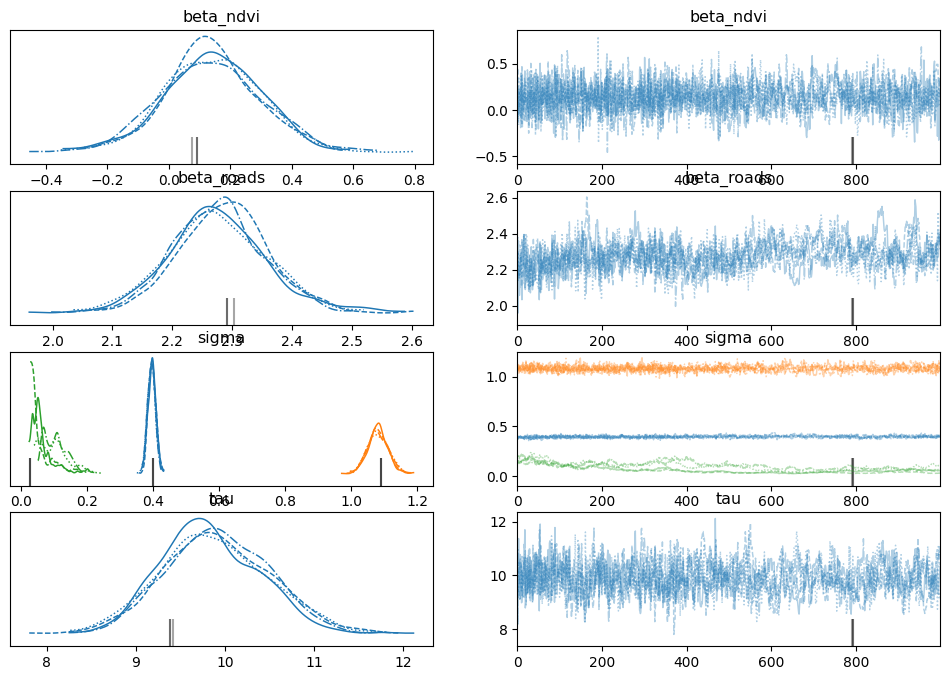

In [46]:
az.plot_trace(trace, var_names=['beta_ndvi','beta_roads','sigma','tau']);

## 6  Posterior mean latent activity map

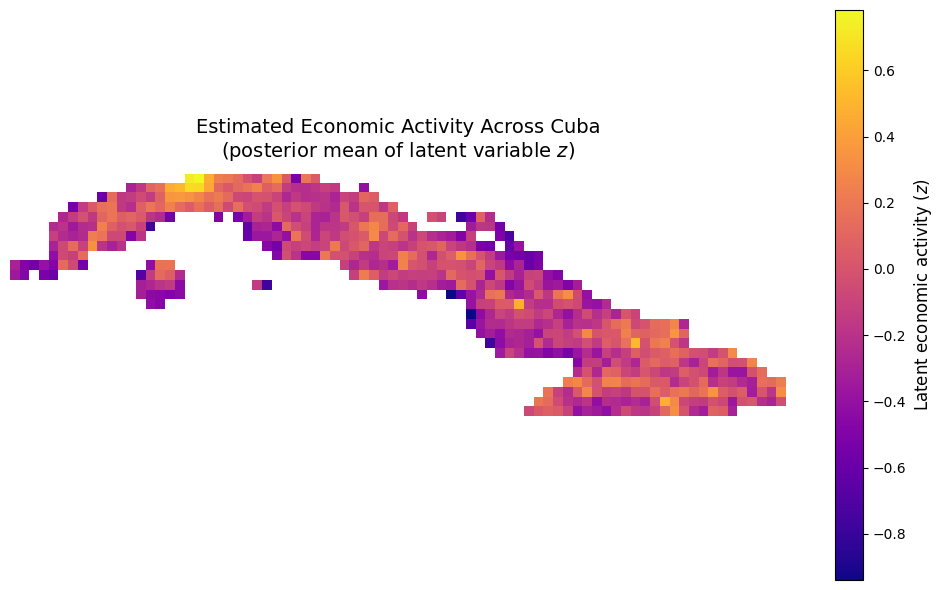

In [50]:
z_raw = trace.posterior["z_raw"].stack(samples=("chain", "draw")).values  # shape (N, S)
tau_samples = trace.posterior["tau"].stack(samples=("chain", "draw")).values  # shape (S,)

# Rescale z_raw using the sampled tau
z = z_raw / np.sqrt(tau_samples)  # shape (N, S)

# Compute posterior mean over samples
z_mean = z.mean(axis=1)  # shape (N,)

lat_map = np.full((ny_coarse, nx_coarse), np.nan)
for k, (r, c) in enumerate(valid):
    lat_map[r, c] = z_mean[k]

plt.figure(figsize=(10, 6))

im = plt.imshow(lat_map, cmap="plasma")
plt.title("Estimated Economic Activity Across Cuba\n(posterior mean of latent variable $z$)", fontsize=14, pad=12)
cbar = plt.colorbar(im)
cbar.set_label("Latent economic activity ($z$)", fontsize=12)

plt.axis("off")  # cleaner
plt.tight_layout()
plt.show()


## QUANTIFYING UNCERTAINTY

In [51]:
z_samples = z_raw / np.sqrt(tau_samples)  # shape (N, S)
z_std = z_samples.std(axis=1)  # shape (N,)

uncert_map = np.full((ny_coarse, nx_coarse), np.nan)
for k, (r, c) in enumerate(valid):
    uncert_map[r, c] = z_std[k]

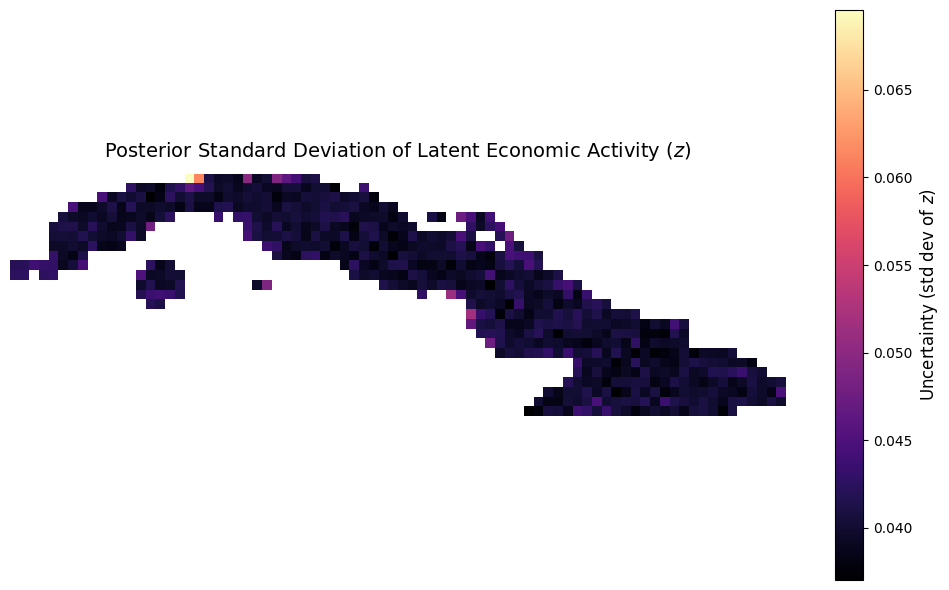

In [52]:
plt.figure(figsize=(10, 6))
im = plt.imshow(uncert_map, cmap="magma")
plt.title("Posterior Standard Deviation of Latent Economic Activity ($z$)", fontsize=14, pad=12)
cbar = plt.colorbar(im)
cbar.set_label("Uncertainty (std dev of $z$)", fontsize=12)
plt.axis("off")
plt.tight_layout()
plt.show()